# CS 109A Final Project: Mortality Prediction and Interpretation

### Group 50: Christie Hung, Raymond So, Chris Sun, Erica Wu

In [1]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import gridspec

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

from collections import Counter
from sklearn.utils import shuffle
from sklearn.linear_model import Lasso
from sklearn.inspection import permutation_importance

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

import shap

# import data and do initial exploratory analysis 
We first imported the data and did initial exploratory analysis - we explored what the distribution of missing data was. FLAG data means that that observation had missing data. 

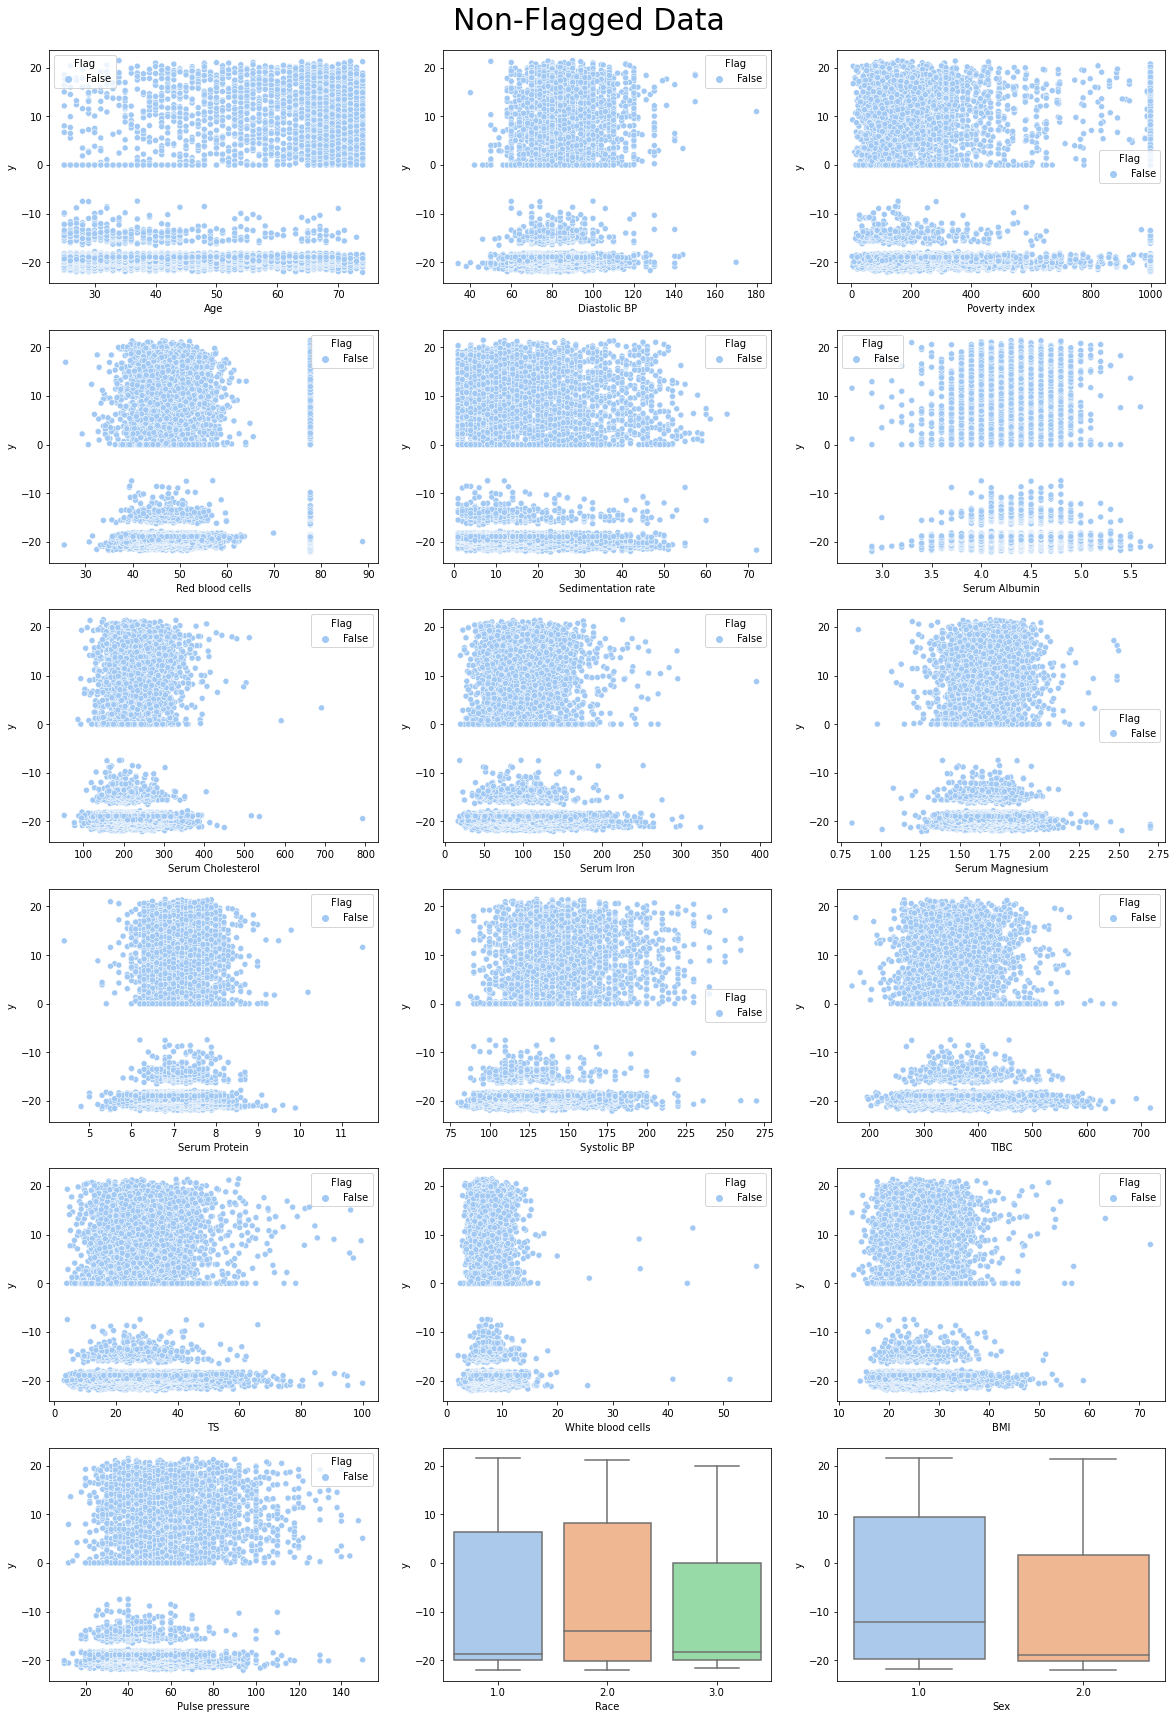

In [2]:
x = pd.read_csv("NHANESI_X.csv")
x['Flag'] = False
for col in x.columns:
    x.loc[x[col].isnull(), 'Flag'] = True
    
y = pd.read_csv("NHANESI_y.csv")
df = x.merge(y)
df = df.drop('Unnamed: 0', axis=1)

# differentiate between categorical and quantitative variables
predictors_cat = ['Race', 'Sex']
predictors_quant = ['Age', 'Diastolic BP', 'Poverty index', 'Red blood cells',
       'Sedimentation rate', 'Serum Albumin', 'Serum Cholesterol',
       'Serum Iron', 'Serum Magnesium', 'Serum Protein', 'Systolic BP',
       'TIBC', 'TS', 'White blood cells', 'BMI', 'Pulse pressure']

# look at distribution of data points without missing data
fig, axes = plt.subplots(6, 3, figsize=(20,30))

for col, ax in zip(predictors_quant, axes.reshape(-1)[:-2]):
    sns.scatterplot(x=col, y='y', data=df[df['Flag'] == False], ax=ax, palette='pastel', hue='Flag')

for col, ax in zip(predictors_cat, axes.reshape(-1)[-2:]):
    sns.boxplot(x=col, y='y', data=df[df['Flag'] == False], ax=ax, palette='pastel')
    
fig.suptitle('Non-Flagged Data', fontsize=30, y=.9)
plt.show()

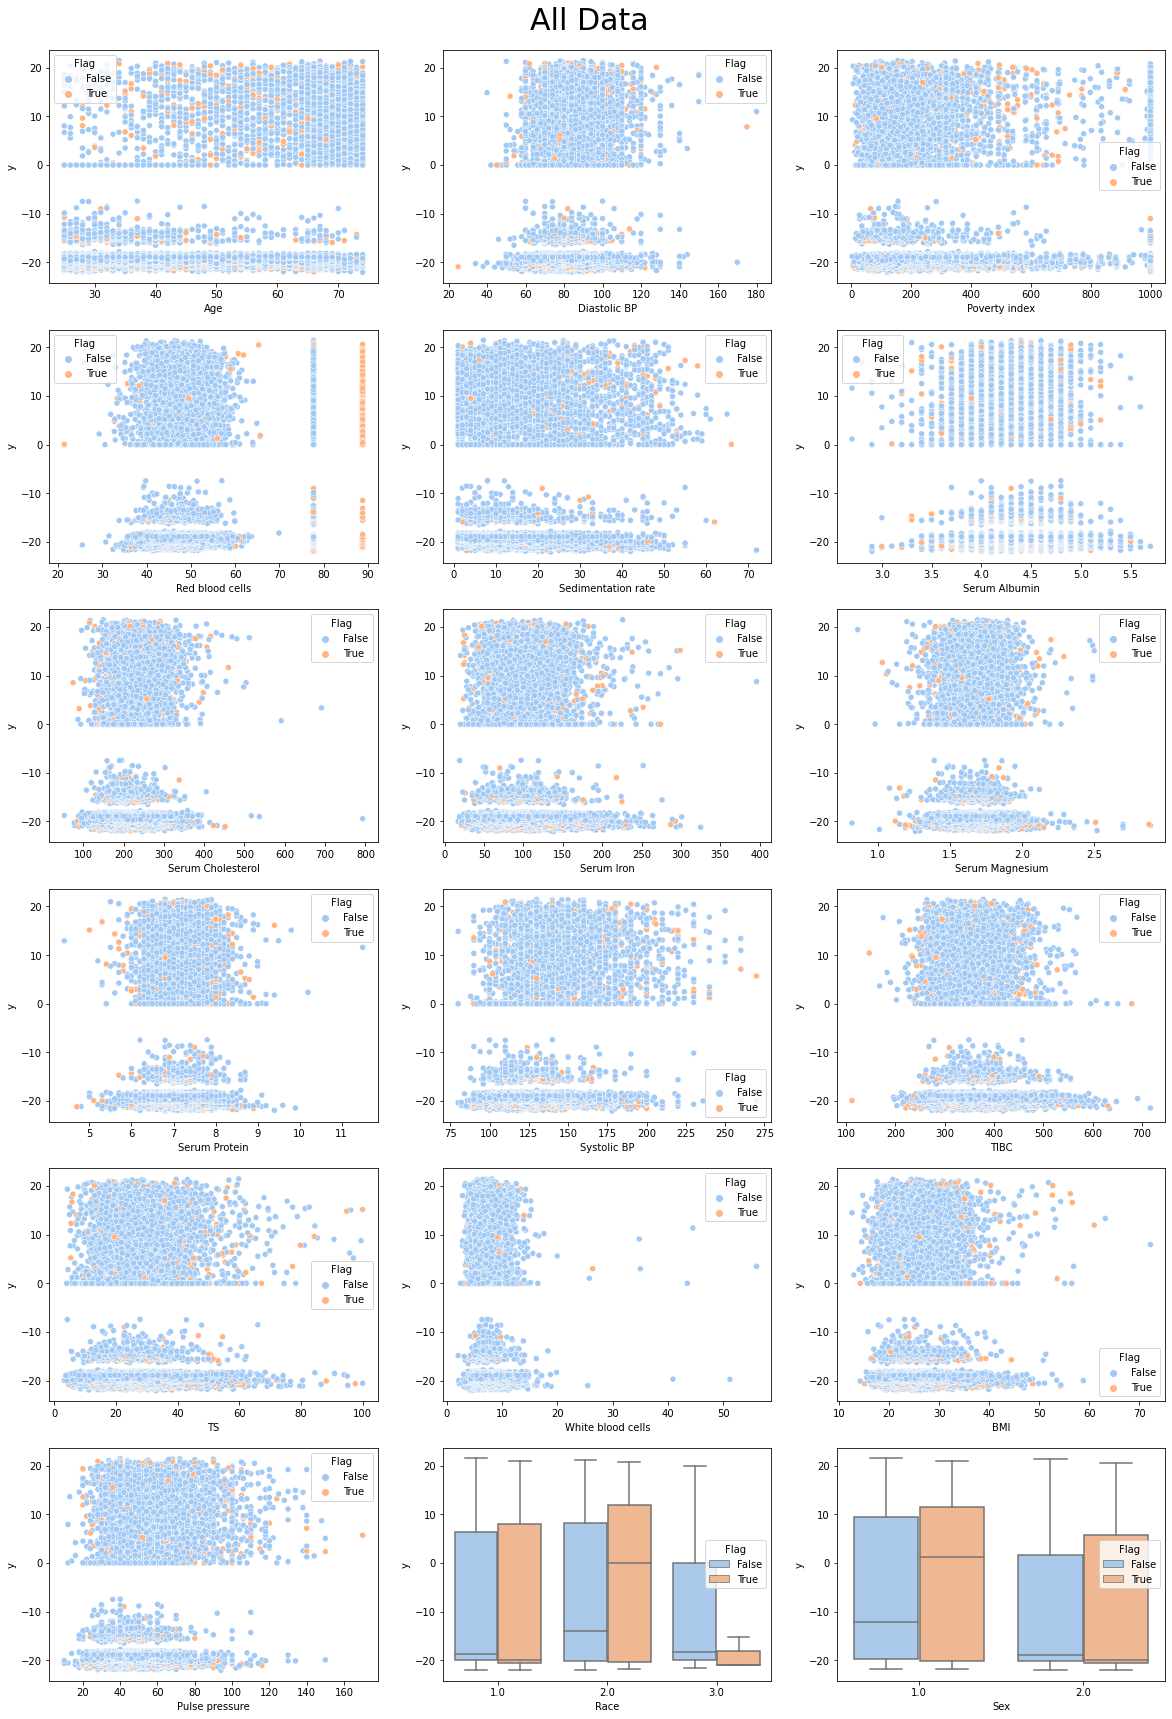

In [3]:
# look at distribution of data with missing data points versus no missing data points
fig, axes = plt.subplots(6, 3, figsize=(20,30))

for col, ax in zip(predictors_quant, axes.reshape(-1)[:-2]):
    sns.scatterplot(x=col, y='y', data=df, ax=ax, palette='pastel', hue='Flag')

for col, ax in zip(predictors_cat, axes.reshape(-1)[-2:]):
    sns.boxplot(x=col, y='y', data=df, ax=ax, palette='pastel', hue='Flag')
    
fig.suptitle('All Data', fontsize=30, y=.9)
plt.show()    

# impute the data

We looked at where there was missing data and decided to do mean imputation of the data where there was missing data. Because we saw that there were values classified as "unacceptable" and "blank," we did mean imputation on the data. This was general processing of the data.

In [4]:
x_data = pd.read_csv("NHANESI_X.csv", index_col = 0)
y_data = pd.read_csv("NHANESI_y.csv", index_col = 0)

# determine which variables are missing values
x_data.isnull().sum(), y_data.isnull().sum()

(Age                      0
 Diastolic BP            58
 Poverty index            0
 Race                     0
 Red blood cells          0
 Sedimentation rate     826
 Serum Albumin            0
 Serum Cholesterol        0
 Serum Iron               0
 Serum Magnesium          0
 Serum Protein            0
 Sex                      0
 Systolic BP             57
 TIBC                     0
 TS                       0
 White blood cells     1041
 BMI                      0
 Pulse pressure          59
 dtype: int64,
 y    0
 dtype: int64)

In [5]:
# deal with "Unacceptable" and "Blank" values in the NHANES data
x_data['Red blood cells'] = [i if i < 88.8 else np.NaN for i in x_data['Red blood cells'].values]
x_data['Red blood cells'] = [i if i != 77.7 else np.NaN for i in x_data['Red blood cells'].values]
x_data["Red blood cells"].fillna(np.mean(x_data["Red blood cells"].dropna()), inplace=True)

x_data['Poverty index'] = [i if i != 999.0 else np.NaN for i in x_data['Poverty index'].values]
x_data["Poverty index"].fillna(np.mean(x_data["Poverty index"].dropna()), inplace=True)

# mean imputation of the data
x_data["Diastolic BP"].fillna(np.mean(x_data["Diastolic BP"].dropna()), inplace=True)
x_data["Sedimentation rate"].fillna(np.mean(x_data["Sedimentation rate"].dropna()), inplace=True)
x_data["Systolic BP"].fillna(np.mean(x_data["Systolic BP"].dropna()), inplace=True)
x_data["White blood cells"].fillna(np.mean(x_data["White blood cells"].dropna()), inplace=True)
x_data["Pulse pressure"].fillna(np.mean(x_data["Pulse pressure"].dropna()), inplace=True)

x_data = x_data.astype('float')

# exploratory data analysis
After doing imputation, we decided to look at the marginal distributions again and begin by looking at correlations between predictors, and looking at interaction plots. 

In [6]:
# get the columns from the dataset 
x_data_col = x_data.columns

# split the data into train and test sets 
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=.8, random_state=109)
train_data = pd.concat([x_train, y_train], axis=1)
test_data = pd.concat([x_test, y_test], axis=1)

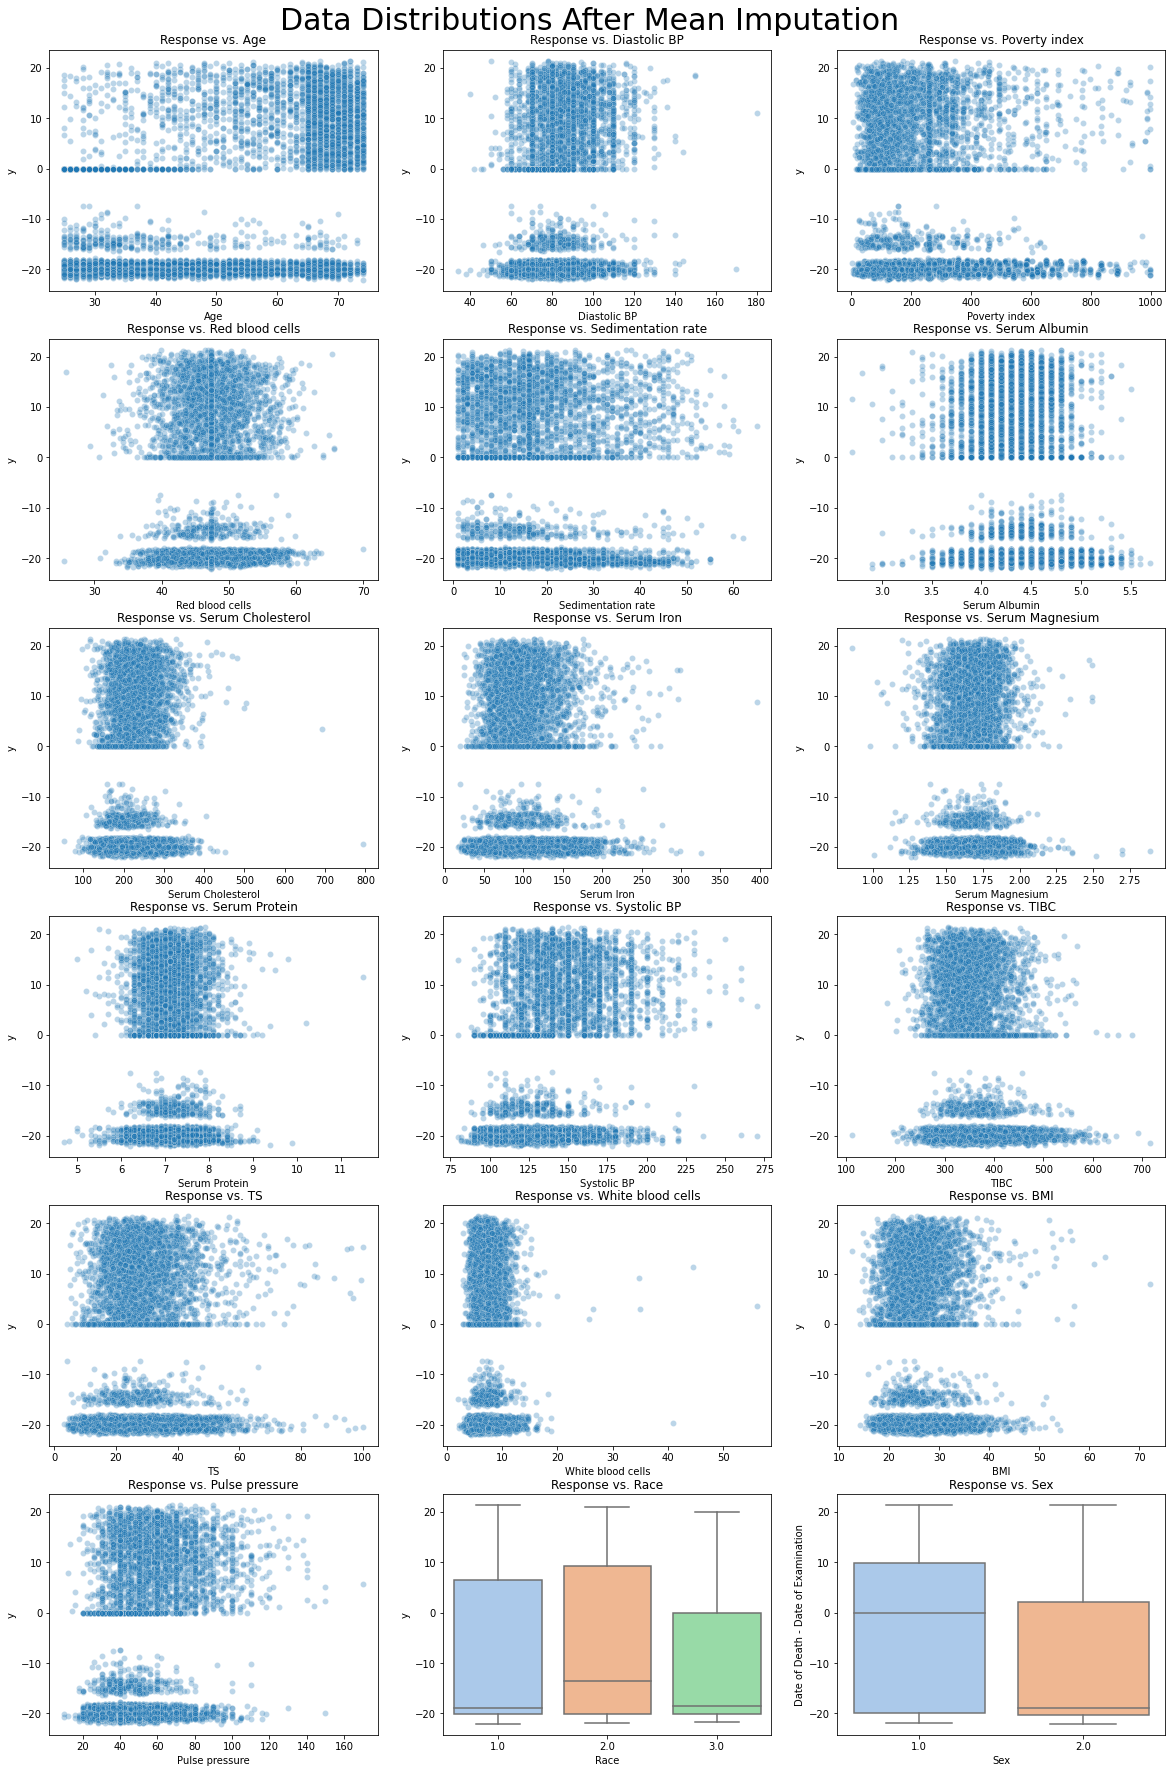

In [7]:
# plot the marginal distributions after imputation
fig, axes = plt.subplots(6, 3, figsize=(20,30))

for col, ax in zip(predictors_quant, axes.reshape(-1)[:-2]):
    sns.scatterplot(x=col, y='y', data=train_data, ax=ax, alpha=0.3, palette='pastel')
    ax.set_title(f'Response vs. {col}')
for col, ax in zip(predictors_cat, axes.reshape(-1)[-2:]):
    sns.boxplot(x=col, y='y', data=train_data, ax=ax, palette='pastel')
    ax.set_title(f'Response vs. {col}')
    
fig.suptitle('Data Distributions After Mean Imputation', fontsize=30, y=.9)
plt.subplots_adjust(bottom=0.1)
plt.ylabel('Date of Death - Date of Examination')
plt.show()

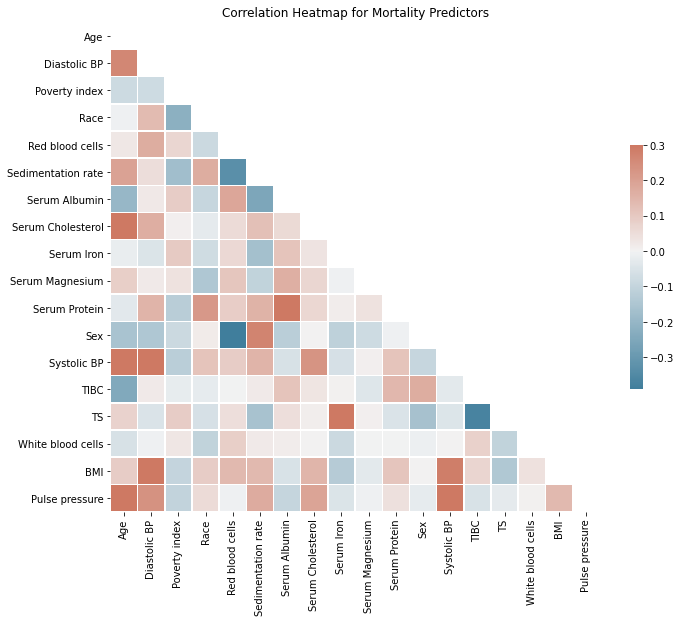

In [8]:
# compute the correlation matrix -- no high correlations
corr = x_train.corr()

# generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap for Mortality Predictors')
plt.show()

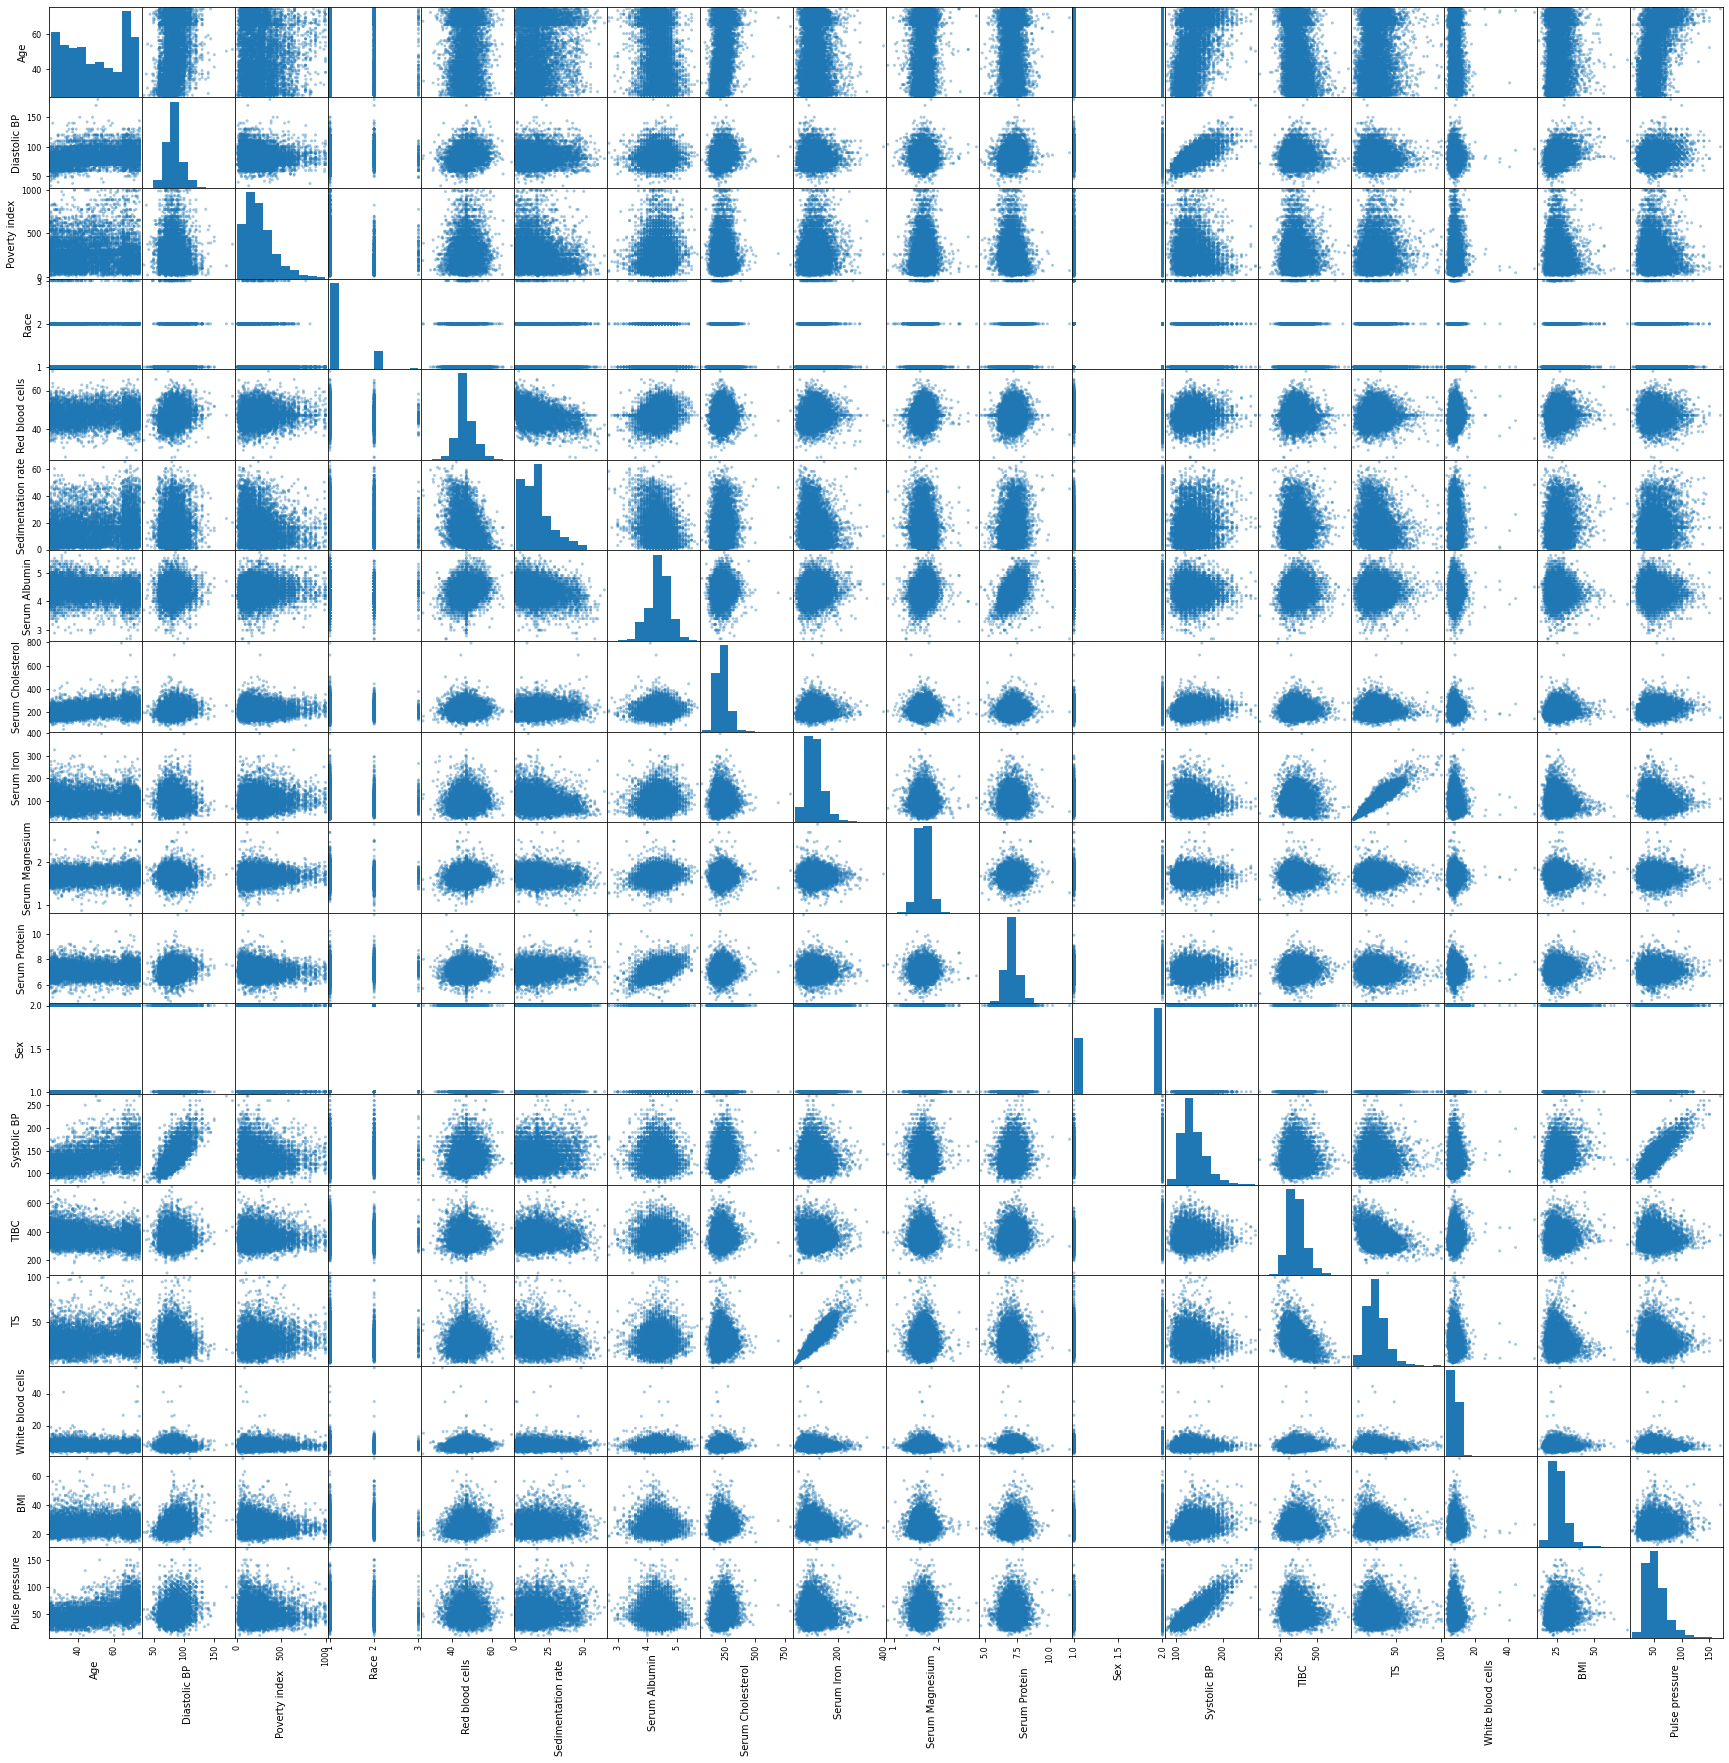

In [9]:
# plot all the predictors against each other 
predictors = x_train.columns
predictors = np.array(predictors)
grid_features = predictors

scatter = pd.plotting.scatter_matrix(x_train[grid_features], alpha=0.4, figsize=(30,30));
for ax in scatter.ravel():
    ax.set_xlabel(ax.get_xlabel(), rotation = 90)
    ax.set_ylabel(ax.get_ylabel(), rotation = 90)

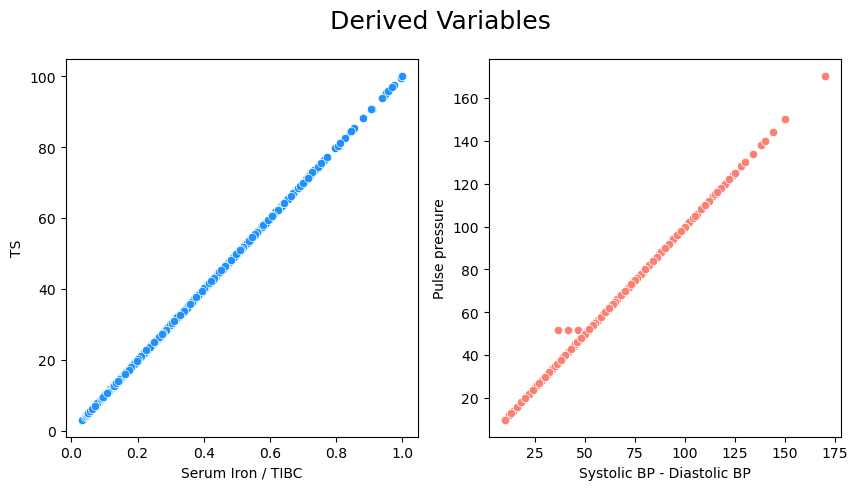

In [10]:
# based on the EDA, we include these graphs to understand the relationship between derived variables and raw variables
fig, axs = plt.subplots(1,2, figsize=(10,5), dpi=100)
sns.scatterplot(x=x_train['Serum Iron'].values / x_train['TIBC'].values, y=x_train["TS"], ax=axs[0], color='dodgerblue')
sns.scatterplot(x=x_train['Systolic BP'].values - x_train['Diastolic BP'].values, y=x_train["Pulse pressure"], ax=axs[1], color='salmon')
axs[0].set_xlabel("Serum Iron / TIBC")
axs[1].set_xlabel("Systolic BP - Diastolic BP")
plt.suptitle("Derived Variables", fontsize=18)
plt.show()

# transform data into classification by setting a threshold at 18 years
Because of the nature of the data, we decided to do a classification task. Here we look at how many values will be thresholded to which class and how many would be dropped under this system. Based on our EDA, we also dropped variables that were derived from other variables. 

In [11]:
# investigate how values would be distributed across classifications -- choose threshold of 18 due to moderate-to-small number of datapoints dropped. 
ones = len(y_data[(y_data["y"] >= 0) & (y_data["y"] <= 18)]) 
zeroes = len(y_data[(y_data["y"] > 18)]) + len(y_data[(y_data["y"] < -18)])
dropped = len(y_data[(y_data["y"] < 0) & (y_data["y"] >= -18)])
print(f'There are {zeroes} with a value of zero.')
print(f'There are {ones} with a value of one.')
print(f'There are {dropped} values dropped.')

There are 6048 with a value of zero.
There are 3470 with a value of one.
There are 414 values dropped.


In [12]:
# let's assume a 18 threshold where there is mortality within 18 years

# drop y-values where we do not know the classification. 
# drop derived variables based on our exploration of the dataset
# transform y-values for classifications

## do it on train set
x_train = x_train.drop(y_train[(y_train["y"] < 0) & (y_train["y"] >= -18)].index)
y_train = y_train.drop(y_train[(y_train["y"] < 0) & (y_train["y"] >= -18)].index)
x_train = x_train.drop(['TS', 'Pulse pressure'], axis = 1)
y_train["class"] = np.nan

y_train.loc[(y_train["y"] > 18) | (y_train["y"] < -18), "class"] = 0
y_train.loc[(y_train["y"] >= 0) & (y_train["y"] <= 18), "class"] = 1

## do it on test Set
x_test = x_test.drop(y_test[(y_test["y"] < 0) & (y_test["y"] >= -18)].index)
y_test = y_test.drop(y_test[(y_test["y"] < 0) & (y_test["y"] >= -18)].index)
x_test = x_test.drop(['TS', 'Pulse pressure'], axis = 1)
y_test["class"] = np.nan

y_test.loc[(y_test["y"] > 18) | (y_test["y"] < -18), "class"] = 0
y_test.loc[(y_test["y"] >= 0) & (y_test["y"] <= 18), "class"] = 1

# concat modified train and test dataframes
train_data = pd.concat([x_train, y_train], axis=1)
test_data = pd.concat([x_test, y_test], axis=1)

In [13]:
# get columns for feature interpretability
x_data_col = x_test.columns
x_train.columns = x_data_col
x_test.columns = x_data_col

In [14]:
# look to see if dataset is imbalanced
# will take care of class imbalance in rest of modeling 

print(sum(y_train['class'] == 0.0), 'datapoints have a class value of 0.0')
print(sum(y_train['class'] == 1.0), 'datapoints have a class value of 1.0')

# make a class_weight dictionary for input into our models described below
class_weight = {0.0: 1, 1.0:1.76}

4858 datapoints have a class value of 0.0
2755 datapoints have a class value of 1.0


# baseline models: logistic regression
We first looked into logistic regression, both regularized and unregularized. 

In [15]:
# create dictionary for storing and comparing model accuracies
report = {}

In [16]:
# clean up our dataframes
y_train = y_train.drop('y', axis=1)
y_train = pd.DataFrame(y_train.values)
y_train.columns = ['class']

y_test = y_test.drop('y', axis=1)
y_test = pd.DataFrame(y_test.values)
y_test.columns = ['class']

The accuracy of the simple logistic regression is: 0.7811
The AUC of the simple logistic regression is: 0.838


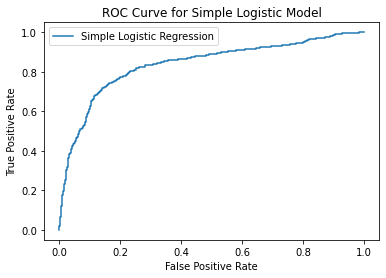

In [17]:
# train a simple logistic regression model
simple_logit = LogisticRegression(class_weight=class_weight, penalty = "none", max_iter=5000).fit(x_train,y_train.values.ravel())

# do predictions to calculate accuracy score and AUC score
simple_pred = simple_logit.predict(x_test)
simple_pred_prob = simple_logit.predict_proba(x_test)[:,1]
fpr_simple, tpr_simple, thresholds_simple = roc_curve(y_test, simple_pred_prob) 

simple_acc = accuracy_score(y_test,simple_pred)

simple_auc = roc_auc_score(y_test,simple_pred_prob)
simple_roc = roc_curve(y_test,simple_pred_prob)

print(f'The accuracy of the simple logistic regression is: {simple_acc:.4}')
print(f'The AUC of the simple logistic regression is: {simple_auc:.4}')

report['Simple Logistic Regression Accuracy Score'] = np.round(simple_acc, 4)
report['Simple Logistic Regression AUC Score'] = np.round(simple_auc, 4)

plt.plot(fpr_simple, tpr_simple, label="Simple Logistic Regression")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC Curve for Simple Logistic Model")
plt.legend()
plt.show()

The accuracy of the simple logistic regression with regularization is: 0.7853
The AUC of the simple logistic regression with regularization is: 0.8388


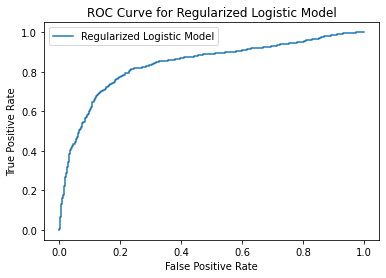

In [18]:
# fit a logistic regression model with regularization
simple_lasso = LogisticRegressionCV(class_weight=class_weight, max_iter=5000).fit(x_train,y_train.values.ravel())

simple_lasso_pred = simple_lasso.predict(x_test)
simple_lasso_pred_prob = simple_lasso.predict_proba(x_test)[:,1]

simple_lasso_acc = accuracy_score(simple_lasso_pred, y_test)
simple_lasso_auc = roc_auc_score(y_test,simple_lasso_pred_prob)
simple_lasso_roc = roc_curve(y_test,simple_lasso_pred_prob)

fpr_simple_lasso, tpr_simple_lasso, thresholds_simple_lasso = roc_curve(y_test, simple_lasso_pred_prob) 

print(f'The accuracy of the simple logistic regression with regularization is: {simple_lasso_acc:.4}')
print(f'The AUC of the simple logistic regression with regularization is: {simple_lasso_auc:.4}')

report['Simple Regularized Logistic Regression Accuracy Score'] = np.round(simple_lasso_acc, 4)
report['Simple Regularized Logistic Regression AUC Score'] = np.round(simple_lasso_auc, 4)

plt.plot(fpr_simple_lasso, tpr_simple_lasso, label="Regularized Logistic Model")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC Curve for Regularized Logistic Model")
plt.legend()
plt.show()

# baseline model: decision trees
We then looked into decision tree models (simple decision tree, random forest, and boosted model). 

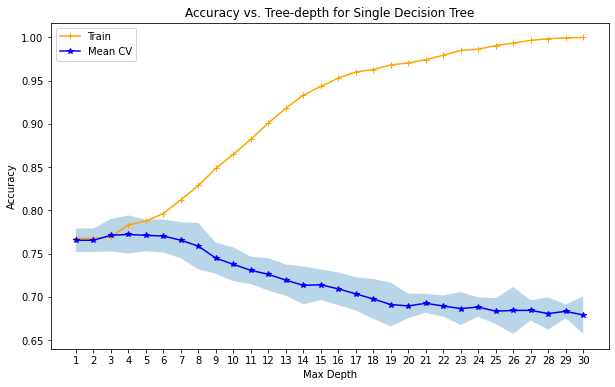

In [19]:
# look for best depth for a simple decision tree
depths = list(range(1, 31)) 
def calc_meanstd(x_train, y_train, depths):
    
   # define variables
    train_scores = []
    cvmeans = []
    cvstds = []
    
    # loop through the various depths
    for d in depths:
        # fit a decision tree to the training set for depths ranging from 1-20
        model = DecisionTreeClassifier(max_depth=d).fit(x_train, y_train)
        
        # evaluate on the training set
        train_scores.append(model.score(x_train, y_train))
        
        # use cross-validation
        scores = cross_val_score(model, x_train, y_train)
        cvmeans.append(scores.mean())
        cvstds.append(scores.std())
    
    return cvmeans, cvstds, train_scores

cvmeans, cvstds, train_scores = calc_meanstd(x_train, y_train, depths)

# plotting
plt.figure(figsize=(10,6))
plt.rcParams["axes.grid"] = False

# plot the initial, non-cross-validation training scores
plt.plot(depths, train_scores, '-+', color="orange", label="Train")

# plot cross-val estimated mean score and shaded region of +/- 2 standard deviations.
plt.plot(depths, cvmeans, '*-', color="blue", label="Mean CV")
cvmeans = np.array(cvmeans)
cvstds = np.array(cvstds)
plt.fill_between(depths, cvmeans-2*cvstds, cvmeans+2*cvstds, alpha=0.3)

# plot labels
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Max Depth")
plt.xticks(depths)
plt.title("Accuracy vs. Tree-depth for Single Decision Tree")
plt.show()

The accuracy of the CV tree is: 0.6992
The AUC of the CV tree is: 0.6825


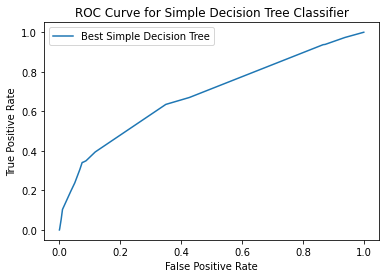

In [20]:
np.random.seed(0)

# fit a decision tree to the training set for max_depth=4
best_cv_tree = DecisionTreeClassifier(class_weight=class_weight, max_depth=4, min_samples_split=13, min_samples_leaf=25, max_features='auto').fit(x_train, y_train)
        
# evaluate accuracy on the training and test set
best_cv_tree_acc = best_cv_tree.score(x_test,y_test)

y_pred = best_cv_tree.predict_proba(x_test)[:,1]
best_cv_tree_auc = roc_auc_score(y_test,y_pred)
fpr_best_cv_tree, tpr_best_cv_tree, thresholds_best_cv_tree = roc_curve(y_test, y_pred)

print(f'The accuracy of the CV tree is: {best_cv_tree_acc:.4}')
print(f'The AUC of the CV tree is: {best_cv_tree_auc:.4}')

report['Simple Decision Tree Classifier Accuracy Score'] = np.round(best_cv_tree_acc, 4)
report['Simple Decision Tree Classifier AUC Score'] = np.round(best_cv_tree_auc, 4)

plt.plot(fpr_best_cv_tree, tpr_best_cv_tree, label="Best Simple Decision Tree")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC Curve for Simple Decision Tree Classifier")
plt.legend()
plt.show()

The accuracy of Adaboost is: 0.7963
The AUC of Adaboost is: 0.8402


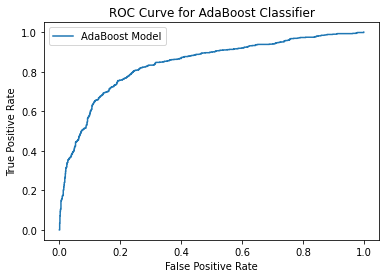

In [21]:
# initialise a Boosting model using sklearn's boosting model 
boosted_model  = AdaBoostClassifier().fit(x_train, y_train.values.ravel())

# evaluate accuracy on the training and test set
boosted_model_acc = boosted_model.score(x_test,y_test)

y_pred = boosted_model.predict_proba(x_test)[:,1]
boosted_model_auc = roc_auc_score(y_test,y_pred)
fpr_boosted_model, tpr_boosted_model, thresholds_boosted_model = roc_curve(y_test, y_pred)

print(f'The accuracy of Adaboost is: {boosted_model_acc:.4}')
print(f'The AUC of Adaboost is: {boosted_model_auc:.4}')

report['AdaBoost Classifier Accuracy Score'] = np.round(boosted_model_acc, 4)
report['AdaBoost Classifier AUC Score'] = np.round(boosted_model_auc, 4)

plt.plot(fpr_boosted_model, tpr_boosted_model, label="AdaBoost Model")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC Curve for AdaBoost Classifier")
plt.legend()
plt.show()

The accuracy of the random forest is: 0.7932
The AUC of the random forest is: 0.843


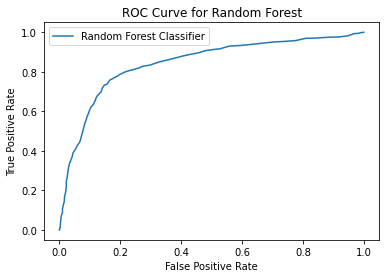

In [22]:
np.random.seed(seed=0)

# fit a RandomForestClassifier model
random_forest = RandomForestClassifier(class_weight=class_weight).fit(x_train, y_train.values.ravel()) 

# evaluate model's accuracy on test set
rf_acc = random_forest.score(x_test,y_test)

y_pred = random_forest.predict_proba(x_test)[:,1]
rf_auc = roc_auc_score(y_test,y_pred)

fpr_random_forest, tpr_random_forest, thresholds_random_forest = roc_curve(y_test, y_pred)

print(f'The accuracy of the random forest is: {rf_acc:.4}')
print(f'The AUC of the random forest is: {rf_auc:.4}')

report['Random Forest Classifier Accuracy Score'] = np.round(rf_acc, 4)
report['Random Forest Classifier AUC Score'] = np.round(rf_auc, 4)

plt.plot(fpr_random_forest, tpr_random_forest, label="Random Forest Classifier")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC Curve for Random Forest")
plt.legend()
plt.show()

# tuned final model
We decided to tune RandomForestClassifier's hyperparameters as our final model using RandomizedSearchCV, as that had given us the best AUC score. This notebook doesn't show RandomizedSearch CV because it takes awhile to run. This model shows the results of the RandomizedSearchCV. 

The accuracy of the optimized random forest is: 0.7969
The AUC of the optimized random forest is: 0.8481


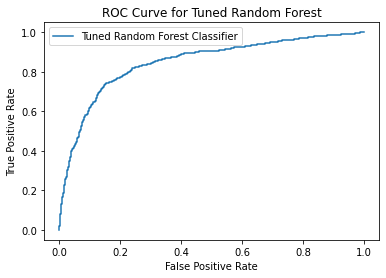

In [23]:
np.random.seed(seed=0)

# fit a RandomForestClassifier model
random_forest = RandomForestClassifier(class_weight=class_weight, min_samples_split=50, min_samples_leaf=1, max_features='sqrt', max_depth=8, n_estimators=55).fit(x_train, y_train.values.ravel()) 

# evaluate model's accuracy on test set
rf_acc = random_forest.score(x_test,y_test)

y_pred = random_forest.predict_proba(x_test)[:,1]
rf_auc = roc_auc_score(y_test,y_pred)

fpr_random_forest, tpr_random_forest, thresholds_random_forest = roc_curve(y_test, y_pred)

print(f'The accuracy of the optimized random forest is: {rf_acc:.4}')
print(f'The AUC of the optimized random forest is: {rf_auc:.4}')

report['Final Random Forest Classifier Accuracy Score'] = np.round(rf_acc, 4)
report['Final Random Forest Classifier AUC Score'] = np.round(rf_auc, 4)

plt.plot(fpr_random_forest, tpr_random_forest, label="Tuned Random Forest Classifier")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC Curve for Tuned Random Forest")
plt.legend()
plt.show()

# feature importance and interpretation of random forest model
Used SHAP values to interpret the model and determine feature importance and interaction terms.

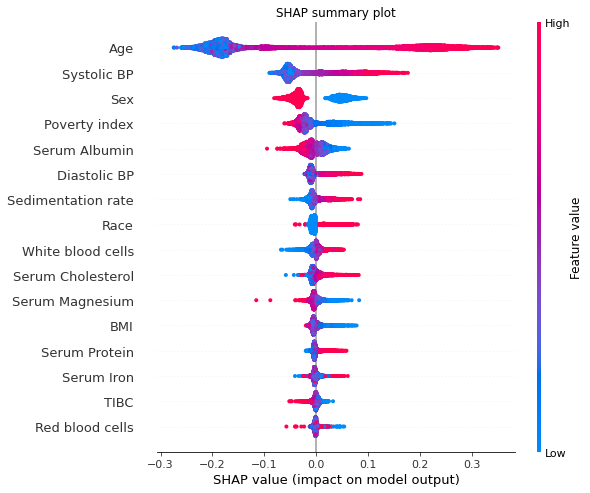

In [24]:
# plot a summary plot to determine global feature importance
shap_values = shap.TreeExplainer(random_forest).shap_values(x_train)
shap.summary_plot(shap_values[1], x_train, plot_type='dot', show=False)
plt.title('SHAP summary plot')
plt.show()

# interaction values
shap_interaction_values = shap.TreeExplainer(random_forest).shap_interaction_values(x_train)

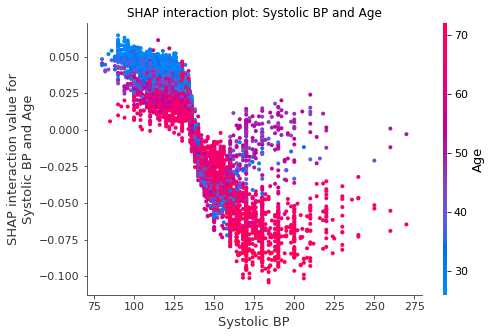

In [25]:
# plot interaction plot with systolic bp and age
shap.dependence_plot(('Systolic BP', 'Age'), shap_interaction_values[1], x_train, show=False)
plt.title('SHAP interaction plot: Systolic BP and Age')
plt.show()

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


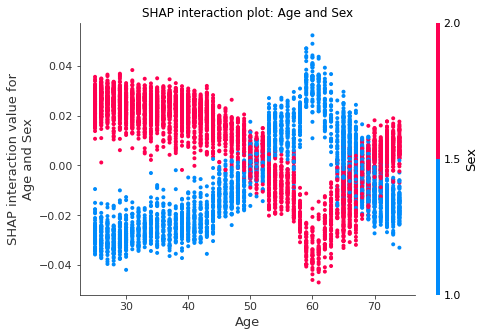

In [26]:
# plot interaction plot with age and sex
shap.dependence_plot(('Age', 'Sex'), shap_interaction_values[1], x_train, show=False)
plt.title('SHAP interaction plot: Age and Sex')
plt.show()

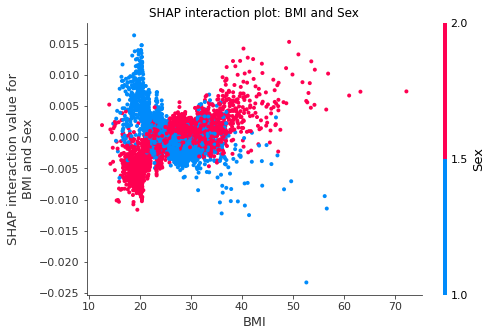

In [27]:
# plot interaction plot with bmi and sex
shap.dependence_plot(('BMI', 'Sex'), shap_interaction_values[1], x_train, show=False)
plt.title('SHAP interaction plot: BMI and Sex')
plt.show()

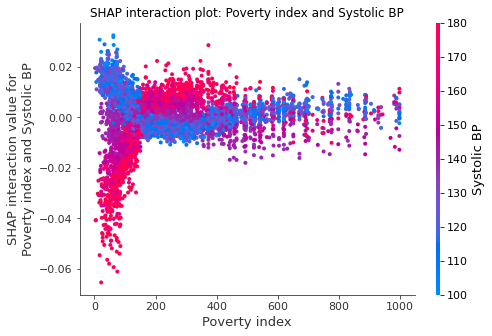

In [28]:
# plot interaction plot with poverty index and systolic bp
shap.dependence_plot(('Poverty index', 'Systolic BP'), shap_interaction_values[1], x_train, show=False)
plt.title('SHAP interaction plot: Poverty index and Systolic BP')
plt.show()

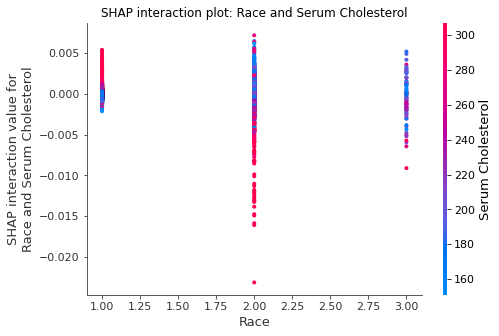

In [29]:
# plot interaction plot with race and serum cholesterol
shap.dependence_plot(('Race', 'Serum Cholesterol'), shap_interaction_values[1], x_train, show=False)
plt.title('SHAP interaction plot: Race and Serum Cholesterol')
plt.show()

# fit a random forest model on the top four predictors
Taking our top four predictors, we wanted to see if we could still train a model using just the top four predictors without compensating the accuracy too much.

The accuracy of the random forest using the top four predictors from SHAP is: 0.7953
The AUC of the optimized random forest using the top four predictors from SHAP is: 0.8449


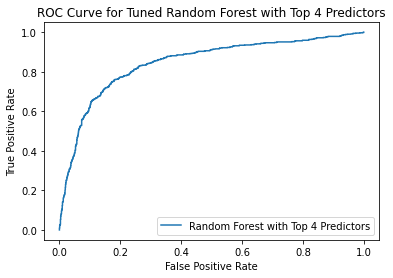

In [30]:
np.random.seed(seed=0)

# fit a RandomForestClassifier model
random_forest_top4 = RandomForestClassifier(class_weight=class_weight, min_samples_split=50, min_samples_leaf=1, max_features='sqrt', max_depth=10, n_estimators=55).fit(x_train[['Age', 'Systolic BP', 'Sex', 'Poverty index']], y_train.values.ravel()) 

# evaluate model's accuracy on test set
rf_acc_top4 = random_forest_top4.score(x_test[['Age', 'Systolic BP', 'Sex', 'Poverty index']], y_test)

y_pred = random_forest_top4.predict_proba(x_test[['Age', 'Systolic BP', 'Sex', 'Poverty index']])[:,1]
rf_auc_top4 = roc_auc_score(y_test,y_pred)

fpr_random_forest_top4, tpr_random_forest_top4, thresholds_random_forest_top4 = roc_curve(y_test, y_pred)

print(f'The accuracy of the random forest using the top four predictors from SHAP is: {rf_acc_top4:.4}')
print(f'The AUC of the optimized random forest using the top four predictors from SHAP is: {rf_auc_top4:.4}')

report['Random Forest with Top Four Predictors Accuracy Score'] = np.round(rf_acc_top4, 4)
report['Random Forest with Top Four Predictors AUC Score'] = np.round(rf_auc_top4, 4)

plt.plot(fpr_random_forest_top4, tpr_random_forest_top4, label="Random Forest with Top 4 Predictors")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC Curve for Tuned Random Forest with Top 4 Predictors")
plt.legend()
plt.show()

In [31]:
report

{'Simple Logistic Regression Accuracy Score': 0.7811,
 'Simple Logistic Regression AUC Score': 0.838,
 'Simple Regularized Logistic Regression Accuracy Score': 0.7853,
 'Simple Regularized Logistic Regression AUC Score': 0.8388,
 'Simple Decision Tree Classifier Accuracy Score': 0.6992,
 'Simple Decision Tree Classifier AUC Score': 0.6825,
 'AdaBoost Classifier Accuracy Score': 0.7963,
 'AdaBoost Classifier AUC Score': 0.8402,
 'Random Forest Classifier Accuracy Score': 0.7932,
 'Random Forest Classifier AUC Score': 0.843,
 'Final Random Forest Classifier Accuracy Score': 0.7969,
 'Final Random Forest Classifier AUC Score': 0.8481,
 'Random Forest with Top Four Predictors Accuracy Score': 0.7953,
 'Random Forest with Top Four Predictors AUC Score': 0.8449}